### Changes to Make

#### Get Citations For End of Bin
- all unique authors and editors
- for each contributor, get all their papers1
- get all papers2 that cite those papers1
- get all years of publication of papers2
- within papers2 filter for at or before end of bin
- this will give us citation count at end of bin

#### Stick with random duplicates

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
"""
aggregate data
"""
def citation_count_plot(author_data, editor_no_dup, editor_rand_dup, journal):
    authors = pd.read_csv(author_data)
    authors = authors.dropna(subset=['AuthorCitationCount'])
    editors_no_dup = pd.read_csv(editor_no_dup)
    editors_rand_dup = pd.read_csv(editor_rand_dup)
    
    author_papers = authors['AuthorCitationCount']
    editor_papers_no_dup = editors_no_dup['CitationCount']
    editor_papers_rand_dup = editors_rand_dup['CitationCount']
    data = [author_papers, editor_papers_no_dup, editor_papers_rand_dup]
    
    fig = plt.figure(figsize =(6,4))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xticklabels(['Authors', 'Editors (No Duplicates)','Editors (Random Duplicates)'])
    bp = ax.boxplot(data)
    plt.title(f'Citation Counts of Authors and Editors at {journal.upper()}')
    plt.show()

In [4]:
def call_citation_count_plot(journal):
    citation_count_plot(f"../author_data/cleaned/{journal}_authors_cleaned.csv", 
                        f"../mag_processed/no_duplicates/{journal}_no_duplicates.csv", 
                        f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv", 
                        journal)

In [5]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [6]:
"""
for authors, all entries are counted
for editors, place them in the first year of their tenure (otherwise there is overcounting)
"""
def citation_count_buckets(author_data, editor_data, journal, bins, labels):
    
    authors = pd.read_csv(author_data)
    editors = pd.read_csv(editor_data)
    authors['Bucket'] = pd.cut(x = authors['PaperYear'], bins = bins, labels = labels, include_lowest = True)
    editors['Bucket'] = pd.cut(x = editors['PaperYear'], bins = bins, labels = labels, include_lowest = True)

    authors = authors.drop_duplicates(subset=['AuthorId'], keep='last')
    authors = authors.drop(labels=['AuthorId', 'Unnamed: 0','PaperId','Year_paper','Year_citation','OriginalAuthor_left','CitesFrom'], axis=1)
    authors = authors.dropna(subset=['Bucket'])
    editors = editors.drop_duplicates(subset=['AuthorId'], keep='last')
    editors = editors.drop(labels=['Unnamed: 0', 'Name_left','Name_right','AuthorId','PaperId','Year_paper','Year_citation','CitesFrom'], axis=1)
    editors = editors.dropna(subset=['Bucket'])

    return authors, editors
    
#     authors = pd.read_csv(author_data)
#     authors = authors.dropna(subset=['AuthorCitationCount'])
#     editors_no_dup = pd.read_csv(editor_no_dup)
#     editors_rand_dup = pd.read_csv(editor_rand_dup)
#     tenures = pd.read_csv(tenures, usecols=['Name', 'Role', 'Start'])
    
#     editors_no_dup = editors_no_dup.merge(tenures, on=['Name'], how='inner')
#     editors_rand_dup = editors_rand_dup.merge(tenures, on=['Name'], how='inner')
    
#     authors['Bucket'] = pd.cut(x = authors['Year'], bins = bins, labels = labels, include_lowest = True)
#     editors_no_dup['Bucket'] = pd.cut(x = editors_no_dup['Start'], bins = bins, labels = labels, 
#                                       include_lowest = True)
#     editors_rand_dup['Bucket'] = pd.cut(x = editors_rand_dup['Start'], bins = bins, labels = labels, 
#                                         include_lowest = True)
    
#     author_papers = []
#     editor_papers_no_dup = []
#     editor_papers_rand_dup = []
    
#     for label in labels:
#         tmp_authors = authors[authors['Bucket'] == label]['AuthorCitationCount']
#         tmp_no_dup = editors_no_dup[editors_no_dup['Bucket'] == label]['CitationCount']
#         tmp_rand_dup = editors_rand_dup[editors_rand_dup['Bucket'] == label]['CitationCount']
#         author_papers.append(tmp_authors)
#         editor_papers_no_dup.append(tmp_no_dup)
#         editor_papers_rand_dup.append(tmp_rand_dup)
    
#     return author_papers, editor_papers_no_dup, editor_papers_rand_dup

In [7]:
def call_citation_count_buckets(journal):
    
    std_bins = [1994, 1998, 2003, 2008, 2013, 2018, 2023]
    std_labels = ['1994-1998', '1999-2003', '2004-2008', '2009-2013', '2014-2018', '2018-2023']
    
    eco_bins = [2007, 2011, 2016, 2021, 2023]
    eco_labels = ['2007-2011', '2012-2016', '2017-2021', '2022-2023']

    jpe_bins = [2017, 2021, 2023]
    jpe_labels = ['2017-2021', '2022-2023']
    
    authors = f"../author_data/citations/{journal}_author_citations.csv"
    editors = f"../editor_data/citations/{journal}_editor_citations.csv"
    if journal == "eco":
        a, e = citation_count_buckets(authors, editors, "eco", eco_bins, eco_labels)
        return a, e, eco_labels
    elif journal == "jpe":
        a, e = citation_count_buckets(authors, editors, "jpe", jpe_bins, jpe_labels)
        return a, e, jpe_labels
    else:
        a, e = citation_count_buckets(authors, editors, journal, std_bins, std_labels)
        return a, e, std_labels

In [10]:
def plot(journal, authors, editors, ticks):
    # rename axes to say citation count and end of tenure/year of publication
    
    plt.rcParams["figure.figsize"] = [7, 6.5]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams.update({'font.size': 8})
    authors = sns.lineplot(data=authors, x="PaperYear", y="PaperCount", errorbar=('ci', 95), color="#f34d4d").set( 
        xlabel=None, ylabel=None
    )
    editors = sns.lineplot(data=editors, x="PaperYear", y="PaperCount", errorbar=('ci', 95), color="#69bade").set(
        xlabel=None, ylabel=None, label="editors"
    )
    sns.despine()
#     plt.legend(['Authors', '', 'Editors'])
    plt.title(f'Number of Citations Received by Contributors Across the "Top Five"', y=1.03)
#     plt.savefig(f'../graphs/aggregate_citations.png')

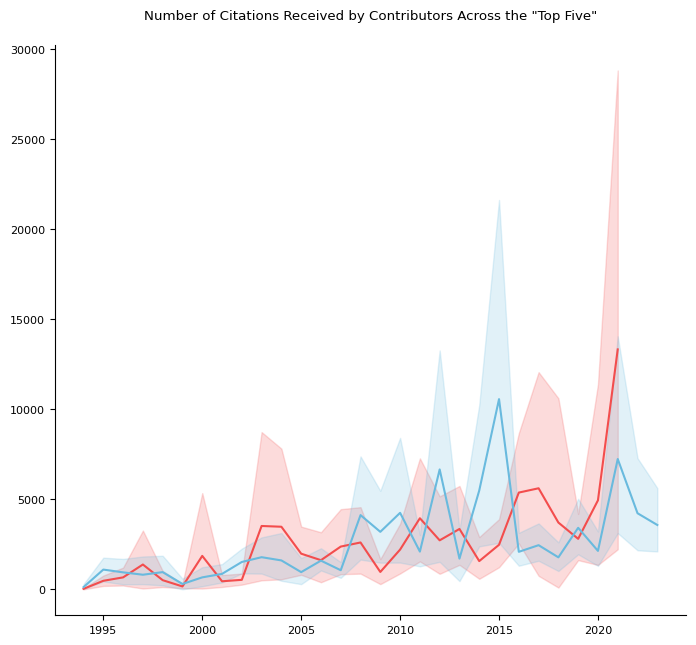

In [11]:
aera, aere, _ = call_citation_count_buckets("aer")
ecoa, ecoe, _ = call_citation_count_buckets("eco")
jpea, jpee, _ = call_citation_count_buckets("jpe")
qjea, qjee, _ = call_citation_count_buckets("qje")
resa, rese, labels = call_citation_count_buckets("res")

aera.head()

all_authors = pd.concat([aera, ecoa, jpea, qjea, resa], ignore_index=True)
all_editors = pd.concat([aere, ecoe, jpee, qjee, rese], ignore_index=True)

plot("agg", all_authors, all_editors, labels)

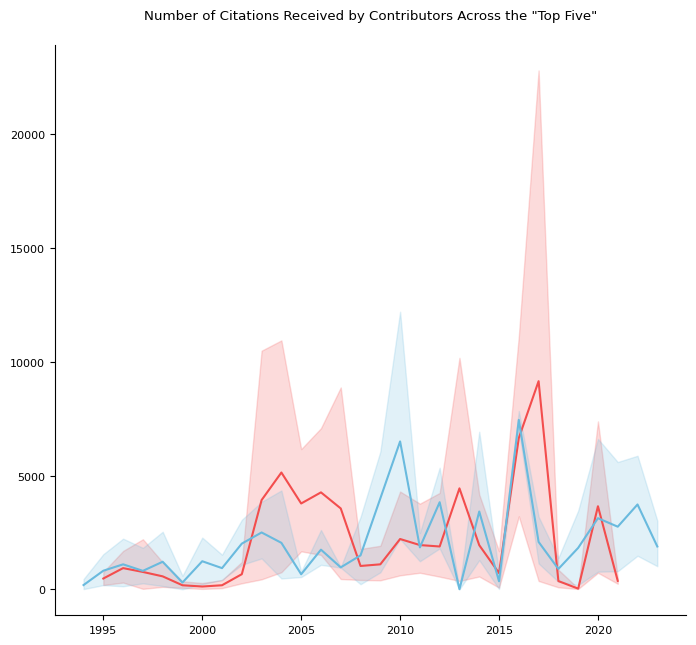

In [12]:
author, editor, labels = call_citation_count_buckets("aer")
plot("aer", author, editor, labels)

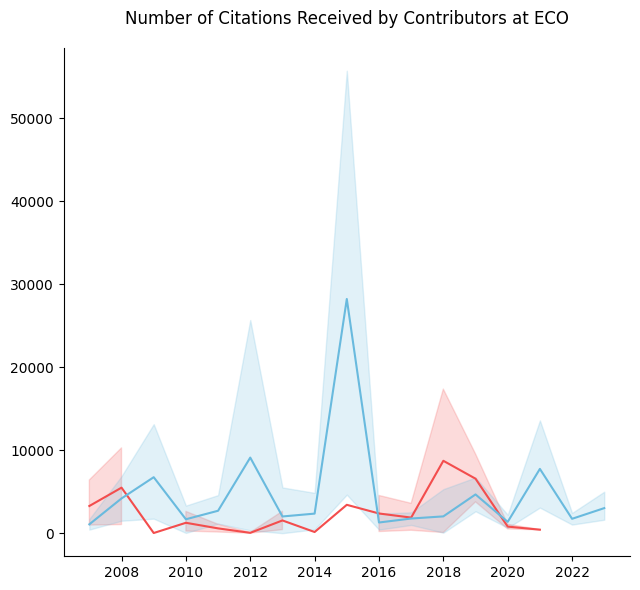

In [39]:
author, editor, labels = call_citation_count_buckets("eco")
plot("eco", author, editor, labels)

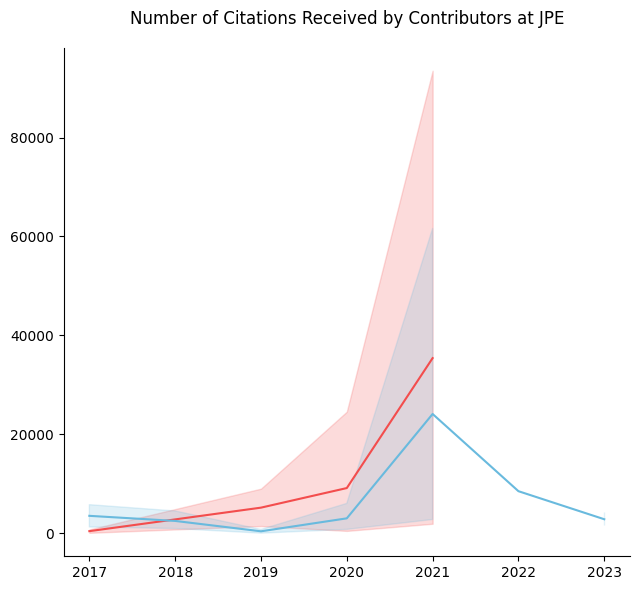

In [40]:
author, editor, labels  = call_citation_count_buckets("jpe")
plot("jpe", author, editor, labels)

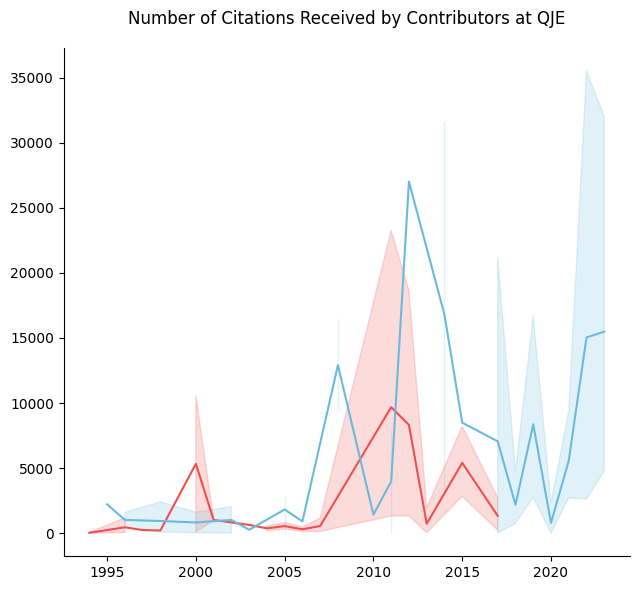

In [41]:
author, editor, labels = call_citation_count_buckets("qje")
plot("qje", author, editor, labels)

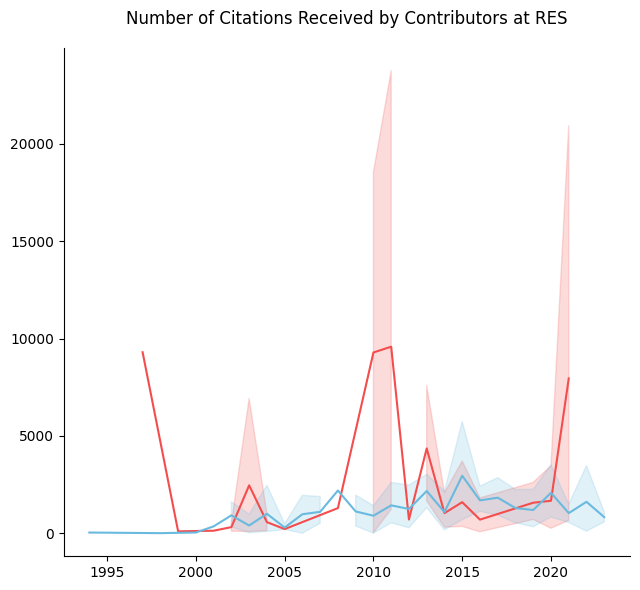

In [42]:
author, editor, labels = call_citation_count_buckets("res")
plot("res", author, editor, labels)